In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import pandas as pd

%matplotlib inline
np.random.seed(1)

2024-04-15 01:00:51.448664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 01:00:51.448943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 01:00:51.471050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 01:00:51.598823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:00:54.012752: W tensorflow/compiler/tf2

Load Data

In [2]:
def load_happy_dataset():
    train_dataset = h5py.File('../datasets/train_happy.h5', 'r')
    train_set_x_og = np.array(train_dataset['train_set_x'][:])
    train_set_y_og = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File('../datasets/test_happy.h5', 'r')
    test_set_x_og = np.array(test_dataset['test_set_x'][:])
    test_set_y_og = np.array(test_dataset['test_set_y'][:])

    classes = np.array(test_dataset['list_classes'][:])

    train_set_y_og = train_set_y_og.reshape((1, train_set_y_og.shape[0]))
    test_set_y_og = test_set_y_og.reshape((1, test_set_y_og.shape[0]))

    return train_set_x_og, train_set_y_og, test_set_x_og, test_set_y_og, classes

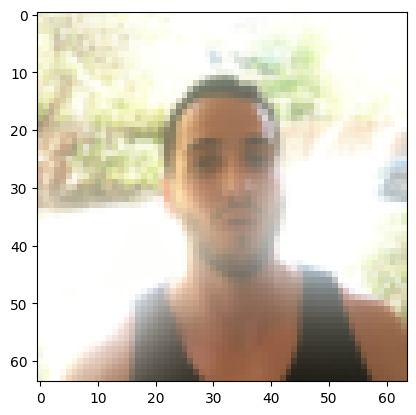

In [3]:
X_train_OG, Y_train_OG, X_test_OG, Y_test_OG, classes = load_happy_dataset()

X_train = X_train_OG/255.
X_test = X_test_OG/255.

Y_train = Y_train_OG.T
Y_test = Y_test_OG.T

index = 42
plt.imshow(X_train_OG[index])
plt.show()

Model using sequential API

In [9]:
def sequential_model():
    model = tf.keras.Sequential([
        tf.keras.layers.ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 3), data_format="channels_last"),
        tf.keras.layers.Conv2D(32, (7, 7), strides=(1, 1), name='conv0'),
        tf.keras.layers.BatchNormalization(axis=3, name='bn0'),
        tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
        tf.keras.layers.MaxPooling2D((2, 2), name='max_pool0'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid', name='fc')
    ])
    return model

sqm = sequential_model()
sqm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
sqm.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
19/19 [==============================] - 2s 12ms/step - loss: 2.2399 - accuracy: 0.5917
Epoch 2/50
19/19 [==============================] - 0s 10ms/step - loss: 0.3059 - accuracy: 0.8617
Epoch 3/50
19/19 [==============================] - 0s 13ms/step - loss: 0.1824 - accuracy: 0.9250
Epoch 4/50
19/19 [==============================] - 0s 11ms/step - loss: 0.1275 - accuracy: 0.9567
Epoch 5/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0964 - accuracy: 0.9733
Epoch 6/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0820 - accuracy: 0.9800
Epoch 7/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0810 - accuracy: 0.9850
Epoch 8/50
19/19 [==============================] - 0s 15ms/step - loss: 0.0730 - accuracy: 0.9833
Epoch 9/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0606 - accuracy: 0.9850
Epoch 10/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0836 - accuracy: 0.9667
Epoch 11/

Model using Functional API

In [23]:
def functional_model(input_shape):
    input_img = tf.keras.Input(input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same')(input_img)
    ## RELU
    A1 = tf.keras.layers.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=(8, 8), padding='same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same')(P1)
    ## RELU
    A2 = tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(A2)
    ## FLATTEN
    F = tf.keras.layers.Flatten()(P2)
    ## Dense layer
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

conv_model = functional_model((64, 64, 3))

In [20]:
X_train.shape, Y_train.shape

((600, 64, 64, 3), (600, 1))

Train the model

In [24]:
conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
19/19 [==============================] - 2s 28ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6776 - val_accuracy: 0.5600
Epoch 2/20
19/19 [==============================] - 0s 16ms/step - loss: 0.6824 - accuracy: 0.6250 - val_loss: 0.6843 - val_accuracy: 0.4867
Epoch 3/20
19/19 [==============================] - 0s 17ms/step - loss: 0.6801 - accuracy: 0.6050 - val_loss: 0.6759 - val_accuracy: 0.6267
Epoch 4/20
19/19 [==============================] - 0s 18ms/step - loss: 0.6716 - accuracy: 0.6367 - val_loss: 0.6674 - val_accuracy: 0.7600
Epoch 5/20
19/19 [==============================] - 0s 18ms/step - loss: 0.6681 - accuracy: 0.6117 - val_loss: 0.6540 - val_accuracy: 0.6600
Epoch 6/20
19/19 [==============================] - 0s 17ms/step - loss: 0.6558 - accuracy: 0.6967 - val_loss: 0.6498 - val_accuracy: 0.7867
Epoch 7/20
19/19 [==============================] - 0s 17ms/step - loss: 0.6416 - accuracy: 0.7900 - val_loss: 0.6375 - val_accuracy: 0.8067
Epoch 8/20
19

Plot loss graph

/tmp/ipykernel_62439/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_62439/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

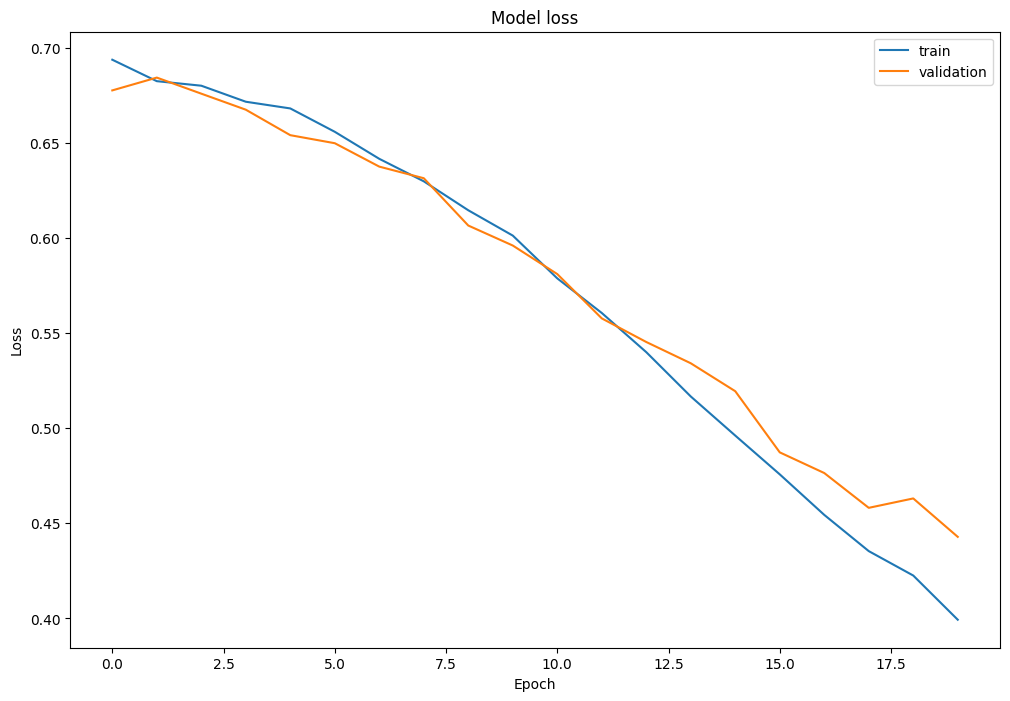

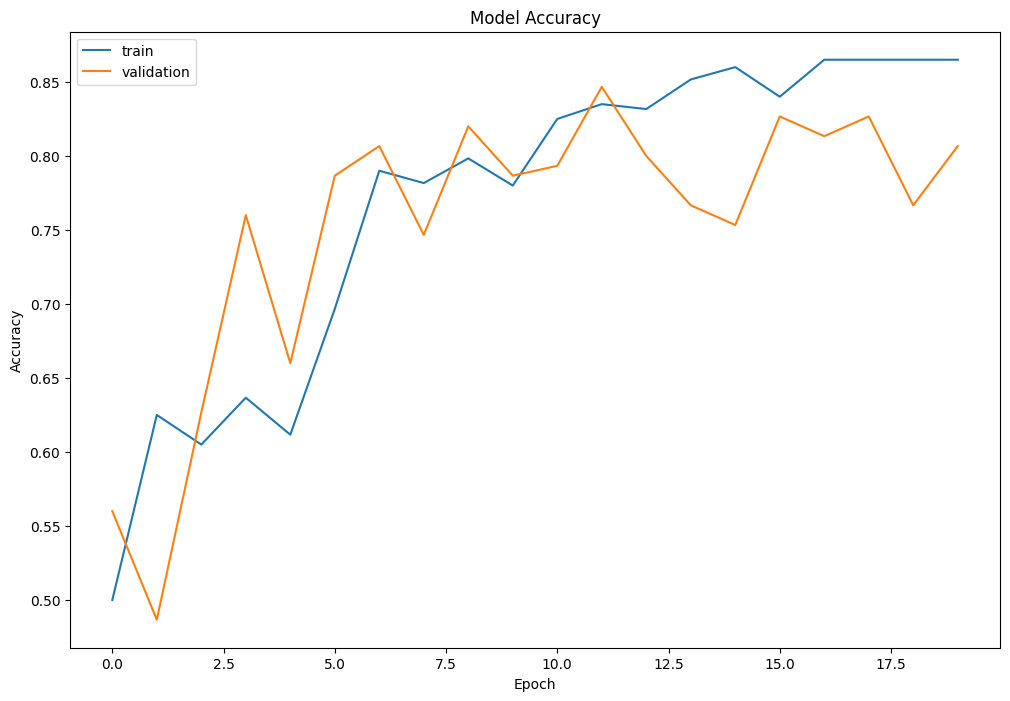

In [25]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')